<a href="https://colab.research.google.com/github/KushagraIndurkhya/bilateral-filtering/blob/main/bilateral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bilateral Filter : Major Project




## Configure opencv and input/output directories and files


In [1]:
!apt-get update
!apt-get install -y libopencv-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,019 kB]
Get:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,549 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,003 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/un

In [2]:
!find .. -name 'libopencv*'

find: ‘../proc/52/task/52/net’: Invalid argument
find: ‘../proc/52/net’: Invalid argument
../var/lib/dpkg/info/libopencv-videostab4.2:amd64.md5sums
../var/lib/dpkg/info/libopencv-objdetect4.2:amd64.list
../var/lib/dpkg/info/libopencv-dnn-dev:amd64.list
../var/lib/dpkg/info/libopencv-ml-dev:amd64.md5sums
../var/lib/dpkg/info/libopencv-features2d4.2:amd64.shlibs
../var/lib/dpkg/info/libopencv-viz-dev:amd64.md5sums
../var/lib/dpkg/info/libopencv-highgui4.2:amd64.md5sums
../var/lib/dpkg/info/libopencv-shape4.2:amd64.triggers
../var/lib/dpkg/info/libopencv-superres-dev:amd64.list
../var/lib/dpkg/info/libopencv-videoio4.2:amd64.list
../var/lib/dpkg/info/libopencv-stitching-dev:amd64.md5sums
../var/lib/dpkg/info/libopencv-dev.md5sums
../var/lib/dpkg/info/libopencv-videostab4.2:amd64.shlibs
../var/lib/dpkg/info/libopencv-imgproc4.2:amd64.list
../var/lib/dpkg/info/libopencv-video-dev:amd64.md5sums
../var/lib/dpkg/info/libopencv-calib3d-dev:amd64.md5sums
../var/lib/dpkg/info/libopencv-photo4.2:a

In [3]:
!pkg-config --cflags --libs opencv4

-I/usr/include/opencv4/opencv -I/usr/include/opencv4 -lopencv_stitching -lopencv_aruco -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_highgui -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_line_descriptor -lopencv_quality -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_datasets -lopencv_text -lopencv_dnn -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [4]:
!mkdir -p output
!mkdir -p input
!wget wget "https://drive.google.com/uc?export=download&id=11A87h7OyeiavThxcRz6OeExEi7u---TC" -O input/original.png


--2023-03-26 16:15:54--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-03-26 16:15:54--  https://drive.google.com/uc?export=download&id=11A87h7OyeiavThxcRz6OeExEi7u---TC
Resolving drive.google.com (drive.google.com)... 108.177.98.139, 108.177.98.100, 108.177.98.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.98.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/esqh9lrgk88efvbtkorfs0cndp76pgq5/1679847300000/07584919166158982710/*/11A87h7OyeiavThxcRz6OeExEi7u---TC?e=download&uuid=1834ab21-fbc1-463e-9ebe-0c157ee40c43 [following]
--2023-03-26 16:15:54--  https://doc-0g-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/esqh9lrgk88efvbtkorfs0cndp76pgq5/1679847300000/07584919166158982710/*/11A87h7OyeiavThxcRz6OeExEi7u---TC?e=download&uuid=1834a

## Add noise to original image apply gaussian,mean,median filters for comparision

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import log10, sqrt

  
def PSNR(im1, im2):
    im1=cv2.imread(im1)
    im2=cv2.imread(im2)
    mse = np.mean((im1-im2) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

   
diameter=3
sigma_for_gaussian=50


img=cv2.imread("input/original.png",0)
gauss_noise=np.zeros(img.shape,dtype=np.uint8)
cv2.randn(gauss_noise,128,10)
gauss_noise=(gauss_noise*0.8).astype(np.uint8)
gn_img=cv2.add(img,gauss_noise)
cv2.imwrite("input/input.png", gn_img)

img=cv2.imread("input/input.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gaussian_blur = cv2.GaussianBlur(gray, (diameter, diameter), sigma_for_gaussian)
cv2.imwrite("output/gaussian_blurred_image.png", gaussian_blur)

mean_filter=cv2.blur(img, (diameter, diameter))
cv2.imwrite("output/mean_filtered_image.png", mean_filter)

median_filter=cv2.medianBlur(img, diameter)
cv2.imwrite("output/median_filtered_image.png", median_filter)



True

# Writing our own bilateral filter implementation sequential and parallel (On CPU) in C++

In [6]:
%%writefile bilateral.cpp

#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <thread>
#include <chrono>

using namespace cv;
using namespace std;

float distance(int x, int y, int i, int j) {
    return float(sqrt(pow(x - i, 2) + pow(y - j, 2)));
}

float gaussian(float x, double sigma) {
    //return exp(-(pow(x, 2))/(2 * pow(sigma, 2))) / (2 * CV_PI * pow(sigma, 2));
    return expf(-0.5f * (x*x) / (sigma* sigma));

}

void applyBilateralFilter(Mat source, Mat filteredImage, int x, int y, int diameter, double sigmaI, double sigmaS) {
    double iFiltered = 0;
    double wP = 0;
    int neighbor_x = 0;
    int neighbor_y = 0;
    int half = diameter / 2;

    for(int i = 0; i < diameter; i++) {
        for(int j = 0; j < diameter; j++) {
            neighbor_x = x - (half - i);
            neighbor_y = y - (half - j);
            double gi = gaussian(source.at<uchar>(neighbor_x, neighbor_y) - source.at<uchar>(x, y), sigmaI);
            double gs = gaussian(distance(x, y, neighbor_x, neighbor_y), sigmaS);
            double w = gi * gs;
            iFiltered = iFiltered + source.at<uchar>(neighbor_x, neighbor_y) * w;
            wP = wP + w;
        }
    }
    iFiltered = iFiltered / wP;
    filteredImage.at<double>(x, y) = iFiltered;


}

Mat addPadding(Mat source, int radius) {
    int row = source.rows;
    int col = source.cols;
    int paddedRow = row + 2 * radius;
    int paddedCol = col + 2 * radius;
    Mat paddedImage = Mat::zeros(paddedRow, paddedCol, source.type());
    for(int i = 0; i < row; i++) {
        for(int j = 0; j < col; j++) {
            paddedImage.at<uchar>(i + radius, j + radius) = source.at<uchar>(i, j);
        }
    }
    return paddedImage;
}


Mat removePadding(Mat source, int radius) {
    int height = source.rows - 2 * radius;
    int width = source.cols - 2 * radius;

    Mat dest = Mat::zeros(height, width,CV_64F); 

    for (int i = radius; i < source.rows - radius; i++) {
        for (int j = radius; j < source.cols - radius; j++) {
            dest.at<uchar>(i - radius, j - radius) = source.at<uchar>(i, j);
        }
    }

    return dest;
}


Mat bilateralFilterSeq(Mat source, int diameter, double sigmaI, double sigmaS) {
    Mat filteredImage = Mat::zeros(source.rows,source.cols,CV_64F);

    //int radius= diameter / 2;
    //source=addPadding(source,radius);
    int radius=0;

    int width = source.cols;
    int height = source.rows;

    for(int i = radius; i < height - radius; i++) {
        for(int j = radius; j < width - radius; j++) {
            applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
        }
    }
    //filteredImage=removePadding(filteredImage,radius);
    return filteredImage;
}

Mat bilateralFilterParallel(Mat source, int diameter, double sigmaI, double sigmaS,int numThreads) {
    Mat filteredImage = Mat::zeros(source.rows, source.cols, CV_64F);
    int radius = 0;

    int width = source.cols;
    int height = source.rows;

    //int numThreads = thread::hardware_concurrency();
    
    vector<thread> threads;

    int rowsPerThread = height / numThreads;

    int start = radius;
    int end = start + rowsPerThread;

    for (int t = 0; t < numThreads; t++) {
        if (t == numThreads - 1) {
            end = height - radius;
        }

        threads.push_back(thread([&, start, end]() {
            for (int i = start; i < end; i++) {
                for (int j = radius; j < width - radius; j++) {
                    applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
                }
            }
        }));

        start = end;
        end = start + rowsPerThread;
    }

    for (auto &t : threads) {
        t.join();
    }

    return filteredImage;
}


int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter= atoi(argv[2]);
    int sigma_space= atoi(argv[3]);
    int sigma_intensity= atoi(argv[4]);
    int numThreads = 10;
    

    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageSeq = bilateralFilterSeq(src, diameter, sigma_intensity,sigma_space);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();


    start = chrono::high_resolution_clock::now();
    Mat filteredImageOpenCV;
    bilateralFilter(src, filteredImageOpenCV, diameter,sigma_intensity,sigma_space);
    end = chrono::high_resolution_clock::now();
    auto durationOpenCV = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    start = chrono::high_resolution_clock::now();
    Mat filteredImageParallel = bilateralFilterParallel(src, diameter, sigma_intensity,sigma_space,numThreads);
    end = chrono::high_resolution_clock::now();
    auto durationParallel = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    cout<<"Sequential: "<<durationSeq<<"ms \n";
    cout<<"Parallel: "<<durationParallel<<"ms"<<" using "<<numThreads<<" threads\n";

    imwrite("output/original_image_grayscale.png", src);
    imwrite("output/filtered_image_OpenCV.png", filteredImageOpenCV);
    imwrite("output/filtered_image_Seq.png", filteredImageSeq);
    imwrite("output/filtered_image_Parallel.png", filteredImageParallel);

    return 0;
}

Writing bilateral.cpp


## Compile and Run

In [7]:
!g++ -std=c++11 -pthread -I/usr/include/opencv4/opencv -I/usr/include/opencv4 bilateral.cpp -o bilateral -lopencv_stitching -lopencv_aruco -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_highgui -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_line_descriptor -lopencv_quality -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_datasets -lopencv_text -lopencv_dnn -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [8]:
!./bilateral input/input.png 15 16 16

Sequential: 7431ms 
Parallel: 4456ms using 10 threads


# Writing our own bilateral filter implementation sequential and parallel (On GPU) in C++

## Not Working

In [ ]:
%%writefile bilateral_cuda.cu
#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>

#define TILE_SIZE 32

using namespace cv;
using namespace std;

__device__ float distance(int x, int y, int i, int j) {
    return float(sqrt(pow(x - i, 2) + pow(y - j, 2)));
}

__device__ double gaussian(float x, double sigma) {
    return exp(-(pow(x, 2))/(2 * pow(sigma, 2))) / (2 * CV_PI * pow(sigma, 2));
}

__global__ void applyBilateralFilterKernel(uchar* source, double* filteredImage, int width, int height, int diameter, double sigmaI, double sigmaS) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int BORDER_SIZE = diameter / 2;
    int extendedWidth = width + BORDER_SIZE;
    int extendedHeight = height + BORDER_SIZE;

    if (x >= BORDER_SIZE / 2 && x < width + BORDER_SIZE / 2 && y >= BORDER_SIZE / 2 && y < height + BORDER_SIZE / 2) {
        double iFiltered = 0;
        double wP = 0;
        int neighbor_x = 0;
        int neighbor_y = 0;
        int half = diameter / 2;

        for(int i = 0; i < diameter; i++) {
            for(int j = 0; j < diameter; j++) {
                neighbor_x = x - (half - i);
                neighbor_y = y - (half - j);
                double gi = gaussian(source[(neighbor_x + BORDER_SIZE / 2) * extendedWidth + neighbor_y + BORDER_SIZE / 2] - source[(x + BORDER_SIZE / 2) * extendedWidth + y + BORDER_SIZE / 2], sigmaI);
                double gs = gaussian(distance(x, y, neighbor_x, neighbor_y), sigmaS);
                double w = gi * gs;
                iFiltered = iFiltered + source[(neighbor_x + BORDER_SIZE / 2) * extendedWidth + neighbor_y + BORDER_SIZE / 2] * w;
                wP = wP + w;
            }
        }
        iFiltered = iFiltered / wP;
        filteredImage[x * width + y] = iFiltered;
    }
}




Mat bilateralFilterCUDA(Mat source, int diameter, double sigmaI, double sigmaS) {
    int width = source.cols;
    int height = source.rows;

    uchar *dev_source;
    cudaMalloc(&dev_source, width * height * sizeof(uchar));
    cudaMemcpy(dev_source, source.data, width * height * sizeof(uchar), cudaMemcpyHostToDevice);

    double *dev_filteredImage;
    cudaMalloc(&dev_filteredImage, width * height * sizeof(double));
    cudaMemset(dev_filteredImage, 0, width * height * sizeof(double));

    dim3 dimBlock(TILE_SIZE, TILE_SIZE);
    dim3 dimGrid((width + dimBlock.x - 1) / dimBlock.x, (height + dimBlock.y - 1) / dimBlock.y);

    applyBilateralFilterKernel<<<dimGrid, dimBlock>>>(dev_source, dev_filteredImage, width, height, diameter, sigmaI, sigmaS);

    Mat filteredImage = Mat::zeros(height, width, CV_64F);
    cudaDeviceSynchronize();
    cudaMemcpy(filteredImage.ptr<double>(), dev_filteredImage, width * height * sizeof(double), cudaMemcpyDeviceToHost);

    cudaFree(dev_source);
    cudaFree(dev_filteredImage);

    filteredImage.convertTo(filteredImage, CV_8UC1);

    return filteredImage;
}


int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter= atoi(argv[2]);
    int sigma_space= atoi(argv[3]);
    int sigma_intensity= atoi(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_intensity,sigma_space);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    cout<<"Cuda: "<<durationSeq<<"ms \n";

    imwrite("output/cuda_gen.png", filteredImageCuda);
}


Overwriting bilateral_cuda.cu


## Working

In [9]:
%%writefile bilateral_cuda.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

// Function to calculate the gaussian weight based on intensity difference
__device__ float gaussianIntensity(float intensity_diff, float sigma_intensity) {
    return expf(-0.5f * (intensity_diff * intensity_diff) / (sigma_intensity * sigma_intensity));
}

// Function to calculate the gaussian weight based on spatial distance
__device__ float gaussianSpace(float spatial_distance, float sigma_space) {
    return expf(-0.5f * (spatial_distance * spatial_distance) / (sigma_space * sigma_space));
}

__global__ void bilateralFilterKernel(const unsigned char* src, unsigned char* dst, int rows, int cols, int diameter, float sigma_space, float sigma_intensity) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= cols || y >= rows) {
        return;
    }

    float intensity_sum = 0;
    float weight_sum = 0;

    for (int j = -diameter; j <= diameter; j++) {
        for (int i = -diameter; i <= diameter; i++) {
            int neighbor_x = x + i;
            int neighbor_y = y + j;

            if (neighbor_x < 0 || neighbor_y < 0 || neighbor_x >= cols || neighbor_y >= rows) {
                continue;
            }

            int src_index = neighbor_y * cols + neighbor_x;
            int dst_index = y * cols + x;

            float intensity_diff = src[src_index] - src[dst_index];
            float spatial_distance = sqrt((float)(i * i + j * j));
            float weight = gaussianIntensity(intensity_diff, sigma_intensity) * gaussianSpace(spatial_distance, sigma_space);

            intensity_sum += src[src_index] * weight;
            weight_sum += weight;
        }
    }

    dst[y * cols + x] = (unsigned char)(intensity_sum / weight_sum);
}

Mat bilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    int rows = src.rows;
    int cols = src.cols;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    bilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols, diameter, sigma_space, sigma_intensity);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/cuda_gen.png", filteredImageCuda);
}


Writing bilateral_cuda.cu


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [10]:
!nvcc -o bilateral_cuda bilateral_cuda.cu `pkg-config --cflags --libs opencv4`


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/videostab/motion_stabilizing.hpp(106): warning #997-D: function "cv::videostab::IMotionStabilizer::stabilize(int, const std::vector<cv::

## Compile and run

In [15]:
%%shell
nvprof ./bilateral_cuda input/input.png 15 16 16
ncu ./bilateral_cuda input/input.png 15 16 16

==11031== NVPROF is profiling process 11031, command: ./bilateral_cuda input/input.png 15 16 16
Cuda: 271ms 
==11031== Profiling application: ./bilateral_cuda input/input.png 15 16 16
==11031== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   99.30%  9.3423ms         1  9.3423ms  9.3423ms  9.3423ms  bilateralFilterKernel(unsigned char const *, unsigned char*, int, int, int, float, float)
                    0.48%  45.312us         2  22.656us  22.304us  23.008us  [CUDA memcpy HtoD]
                    0.22%  20.575us         1  20.575us  20.575us  20.575us  [CUDA memcpy DtoH]
      API calls:   95.58%  214.70ms         2  107.35ms  5.5560us  214.69ms  cudaMalloc
                    4.26%  9.5794ms         3  3.1931ms  82.822us  9.4113ms  cudaMemcpy
                    0.07%  167.71us       101  1.6600us     246ns  67.511us  cuDeviceGetAttribute
                    0.05%  117.43us         2  58.715us  11.218us  106.21

## Gaussian-spatial precompute optimization

In [21]:
%%writefile bilateral_cuda_opt1.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

// Function to calculate the gaussian weight based on intensity difference
__device__ float gaussianIntensity(float intensity_diff, float sigma_intensity) {
    return expf(-0.5f * (intensity_diff * intensity_diff) / (sigma_intensity * sigma_intensity));
}

// Function to calculate the gaussian weight based on spatial distance
__device__ float gaussianSpace(float spatial_distance, float sigma_space) {
    return expf(-0.5f * (spatial_distance * spatial_distance) / (sigma_space * sigma_space));
}

__global__ void bilateralFilterKernel(const unsigned char* src, unsigned char* dst, int rows, int cols, int diameter, float sigma_space, float sigma_intensity,float* spatial_lookup) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= cols || y >= rows) {
        return;
    }

    float intensity_sum = 0;
    float weight_sum = 0;

    for (int j = -diameter; j <= diameter; j++) {
        for (int i = -diameter; i <= diameter; i++) {
            int neighbor_x = x + i;
            int neighbor_y = y + j;

            if (neighbor_x < 0 || neighbor_y < 0 || neighbor_x >= cols || neighbor_y >= rows) {
                continue;
            }

            int src_index = neighbor_y * cols + neighbor_x;
            int dst_index = y * cols + x;

            float intensity_diff = src[src_index] - src[dst_index];
            float spatial_weight = spatial_lookup[(i+diameter)*diameter+(j+diameter)];
            float weight = gaussianIntensity(intensity_diff, sigma_intensity) * spatial_weight;


            intensity_sum += src[src_index] * weight;
            weight_sum += weight;
        }
    }

    dst[y * cols + x] = (unsigned char)(intensity_sum / weight_sum);
}

float* computeSpatialLookup(int diameter, float sigma_space) {
    int max_distance = 2*diameter+1;
    float* spatial_lookup = new float[max_distance*max_distance];
    float spatial_distance;
    int t_i, t_j;

    for (int i = 0; i <= max_distance; i++) {
      for (int j=0; j<=max_distance; j++) {
        t_i = i-diameter;
        t_j = j-diameter;
        spatial_distance = sqrt((float)(t_i * t_i + t_j * t_j));
        spatial_lookup[i*diameter + j] = expf(-0.5f * spatial_distance / (sigma_space * sigma_space));
      }
    }

    return spatial_lookup;
}

Mat bilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    float* dev_spatial_lookup;
    int rows = src.rows;
    int cols = src.cols;
    float* SpatialLookup=computeSpatialLookup(diameter,sigma_space);

    int lookup_row = 2*diameter+1;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_spatial_lookup, sizeof(float)*lookup_row*lookup_row);

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_spatial_lookup, SpatialLookup, sizeof(float)*lookup_row*lookup_row, cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);


    bilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols, diameter, sigma_space, sigma_intensity,dev_spatial_lookup);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/cuda_gen_opt1.png", filteredImageCuda);
}

Overwriting bilateral_cuda_opt1.cu


In [22]:
!nvcc -o bilateral_cuda_opt1 bilateral_cuda_opt1.cu `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/videostab/motion_stabilizing.hpp(106): warning #997-D: function "cv::videostab::IMotionStabilizer::stabilize(int, const std::vector<cv::

In [23]:
%%shell
nvprof ./bilateral_cuda_opt1 input/input.png 15 16 16
ncu ./bilateral_cuda_opt1 input/input.png 15 16 16

==14881== NVPROF is profiling process 14881, command: ./bilateral_cuda_opt1 input/input.png 15 16 16
Cuda: 329ms 
==14881== Profiling application: ./bilateral_cuda_opt1 input/input.png 15 16 16
==14881== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   98.99%  6.6787ms         1  6.6787ms  6.6787ms  6.6787ms  bilateralFilterKernel(unsigned char const *, unsigned char*, int, int, int, float, float, float*)
                    0.70%  47.326us         3  15.775us  1.6320us  23.071us  [CUDA memcpy HtoD]
                    0.31%  20.640us         1  20.640us  20.640us  20.640us  [CUDA memcpy DtoH]
      API calls:   97.45%  275.81ms         3  91.937ms  3.9700us  275.80ms  cudaMalloc
                    2.45%  6.9434ms         4  1.7359ms  31.635us  6.7481ms  cudaMemcpy
                    0.06%  176.80us       101  1.7500us     261ns  70.656us  cuDeviceGetAttribute
                    0.01%  31.006us         1  31.006us

# Plot out Results

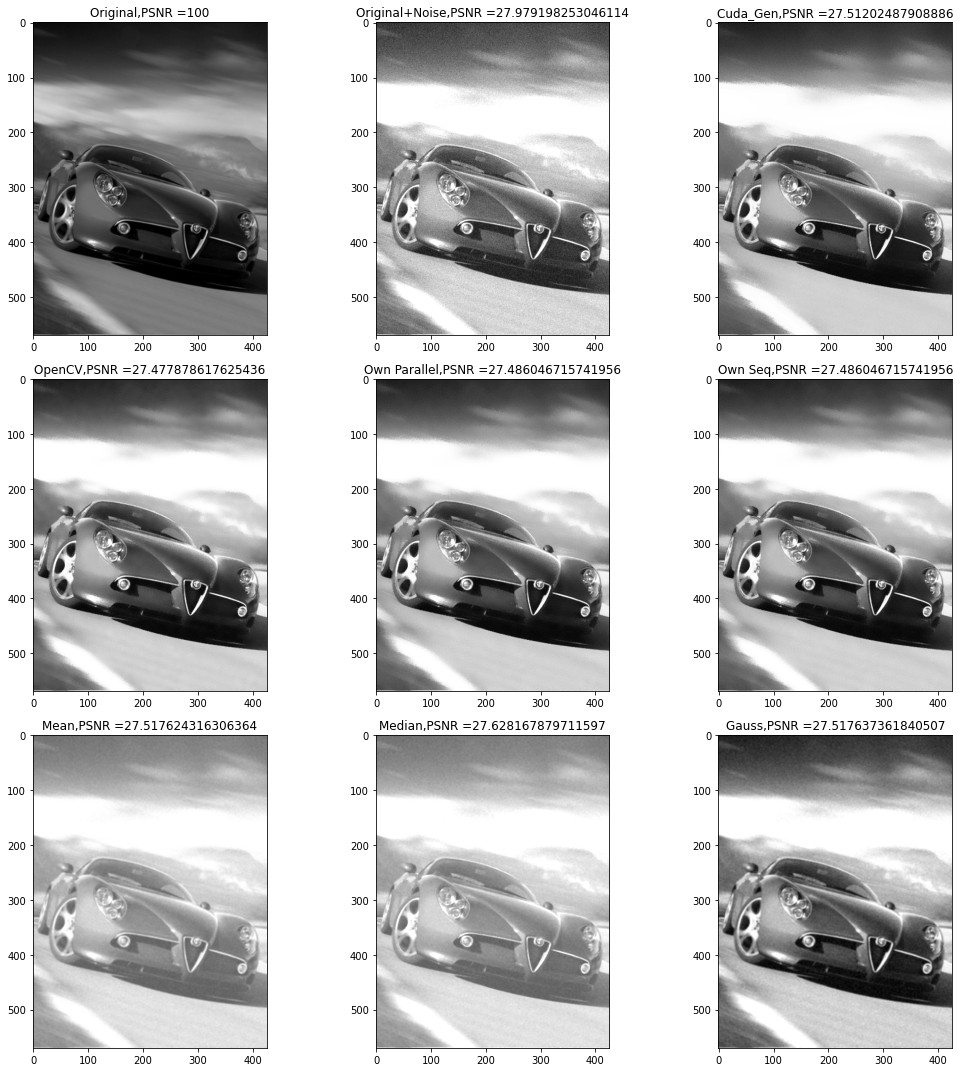

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# base_image_location="output/original_image_grayscale.png"
base_image_location="input/original.png"

img0,im0psnr = mpimg.imread("input/original.png"),PSNR(base_image_location,"input/original.png")
img1,im1psnr = mpimg.imread("output/original_image_grayscale.png"),PSNR(base_image_location,"output/original_image_grayscale.png")
img2,im2psnr = mpimg.imread("output/filtered_image_Parallel.png"),PSNR(base_image_location,"output/filtered_image_Parallel.png")
img3,im3psnr = mpimg.imread("output/filtered_image_Seq.png"),PSNR(base_image_location,"output/filtered_image_Seq.png")
img4,im4psnr = mpimg.imread("output/mean_filtered_image.png"),PSNR(base_image_location,"output/mean_filtered_image.png")
img5,im5psnr = mpimg.imread("output/median_filtered_image.png"),PSNR(base_image_location,"output/median_filtered_image.png")
img6,im6psnr= mpimg.imread("output/gaussian_blurred_image.png"),PSNR(base_image_location,"output/gaussian_blurred_image.png")
img7,im7psnr = mpimg.imread("output/filtered_image_OpenCV.png"),PSNR(base_image_location,"output/filtered_image_OpenCV.png")
img8,im8psnr = mpimg.imread("output/cuda_gen.png"),PSNR(base_image_location,"output/cuda_gen.png")
# img9,imp9snr = mpimg.imread("output/cuda_gen_opt1.png"),PSNR(base_image_location,"output/cuda_gen_opt1.png")



fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs[0,0].imshow(img0, cmap='gray')
axs[0,0].set_title("Original,PSNR ="+str(im0psnr))

axs[0,1].imshow(img1, cmap='gray')
axs[0,1].set_title("Original+Noise,PSNR ="+str(im1psnr))

axs[0,2].imshow(img8, cmap='gray')
axs[0,2].set_title("Cuda_Gen,PSNR ="+str(im8psnr))

# axs[3,1].imshow(img9, cmap='gray')
# axs[3,1].set_title("Cuda_Gen_opt1,PSNR ="+str(im9psnr))

axs[1,0].imshow(img7, cmap='gray')
axs[1,0].set_title("OpenCV,PSNR ="+str(im7psnr))

axs[1,1].imshow(img2, cmap='gray')
axs[1,1].set_title("Own Parallel,PSNR ="+str(im2psnr))

axs[1,2].imshow(img3, cmap='gray')
axs[1,2].set_title("Own Seq,PSNR ="+str(im3psnr))

axs[2,0].imshow(img4, cmap='gray')
axs[2,0].set_title("Mean,PSNR ="+str(im4psnr))

axs[2,1].imshow(img5, cmap='gray')
axs[2,1].set_title("Median,PSNR ="+str(im5psnr))

axs[2,2].imshow(img6, cmap='gray')
axs[2,2].set_title("Gauss,PSNR ="+str(im6psnr))


plt.tight_layout()
plt.show()

In [ ]:
!rm -r input output
!rm bilateral bilateral.cpp